<a name='0'></a>

# Densely Connected Convolutional Networks - DenseNet

After the ImageNet Large Scale Visual Recognition Challenge(ILSVRC), researchers kept finding efficient convolutional neural networks architectures by taking inspirations from previous architectures such as Residual Networks. 


[DenseNet](https://arxiv.org/abs/1608.06993v5) was one of the CNN architectures that didn't participate in ILVRC, but it introduced a new design fashion that is worth talking about.  

### What's in here: 

  * [1. Introduction](#1)
  * [2. DenseNet Architecture](#2)
  * [3. DenseNet Implementation](#3)
  * [4. Final Notes](#4)



<a name='1'></a>

## 1. Introduction

We previously saw how networks were getting bigger and bigger after realizing that depth is essential for performance. ResNet is the first network that took depth to next level by introducing a network with over 100 layers and even showing that a network of 1000 layers can be trained. ResNet main motivation was that deep networks are hard to optimize, not they tend to overfit. With the identity shortcut connections and using batch normalization, they were able to train a network of 152 layers on ImageNet and crashed everyone on ImageNet Challenge 2016 across all tasks (classification, localization, detection and segmentation). 

DenseNet standing for Densely Connected Convolutional Networks took inspiration from GoogLeNet inception modules and ResNet shortcut connections. The principal component is a dense block(more on dense block later). 

Instead of using direct shortcut connections from the input to output, in dense blocks, each layer is connected to every other layer in feed forward regime. Quoting the [paper](https://arxiv.org/abs/1608.06993v5), "*to preserve the feed-forward nature, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers.*" As results, DenseNet has fewer parameters than prior architectures and it is easy to train due to improved information and gradients flow between layers of the network. Dense connections also have some form of regularization and that helps reduce overfitting when working with small training data. Let's now talk about the architecture. 


<a name='2'></a>

## 2. DenseNet Architecture

The basic building block of the DenseNet is a dense block. Dense connections connect every layer to all other subsequent layers (see the diagram). Every layer receives the feature maps from the later layers and these feature maps are concatenated before being fed to the next layer.

Unlike in ResNet where every convolutional layer is followed by batch normalization and ReLU layers, every convolutional layer in DenseNet comes after batch normalization and ReLU activation or this sequence ***Batch norm-ReLU-Conv layer***. 

The dense blocks act as downsampler. The layers between dense blocks are called transition layers and they are batch normalization and 1x1 convolution layer followed by 2x2 average pooling layer. Below is the DenseNet architecture. The image is borrowed from the paper. 

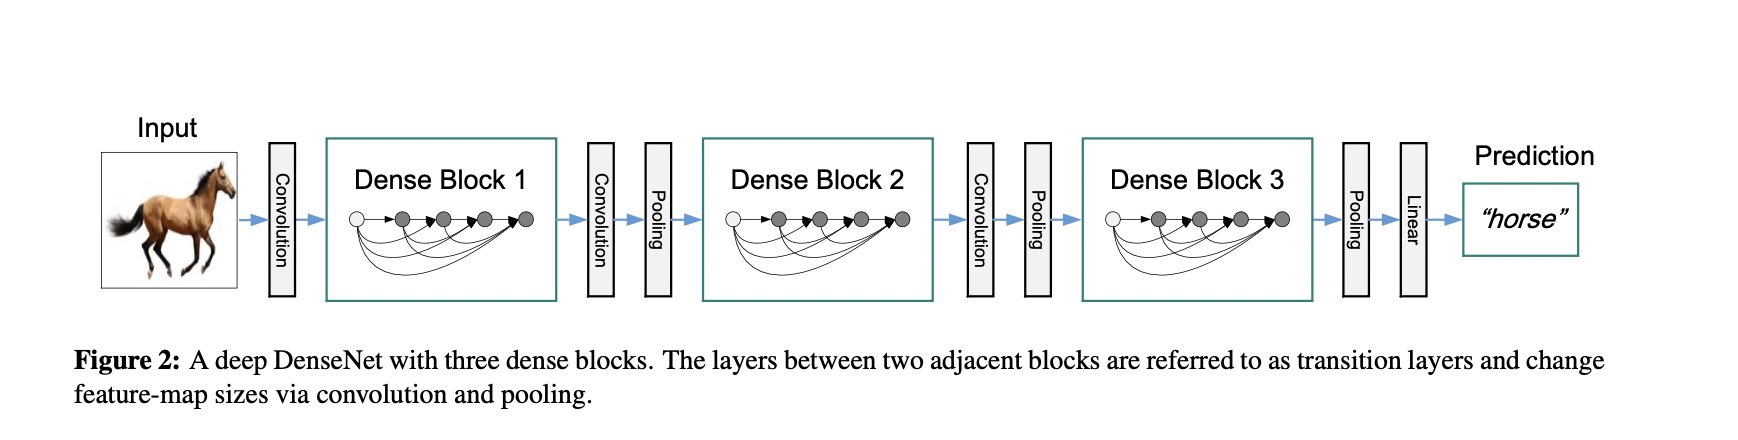

And here is the illustration of the dense block in the DenseNet.

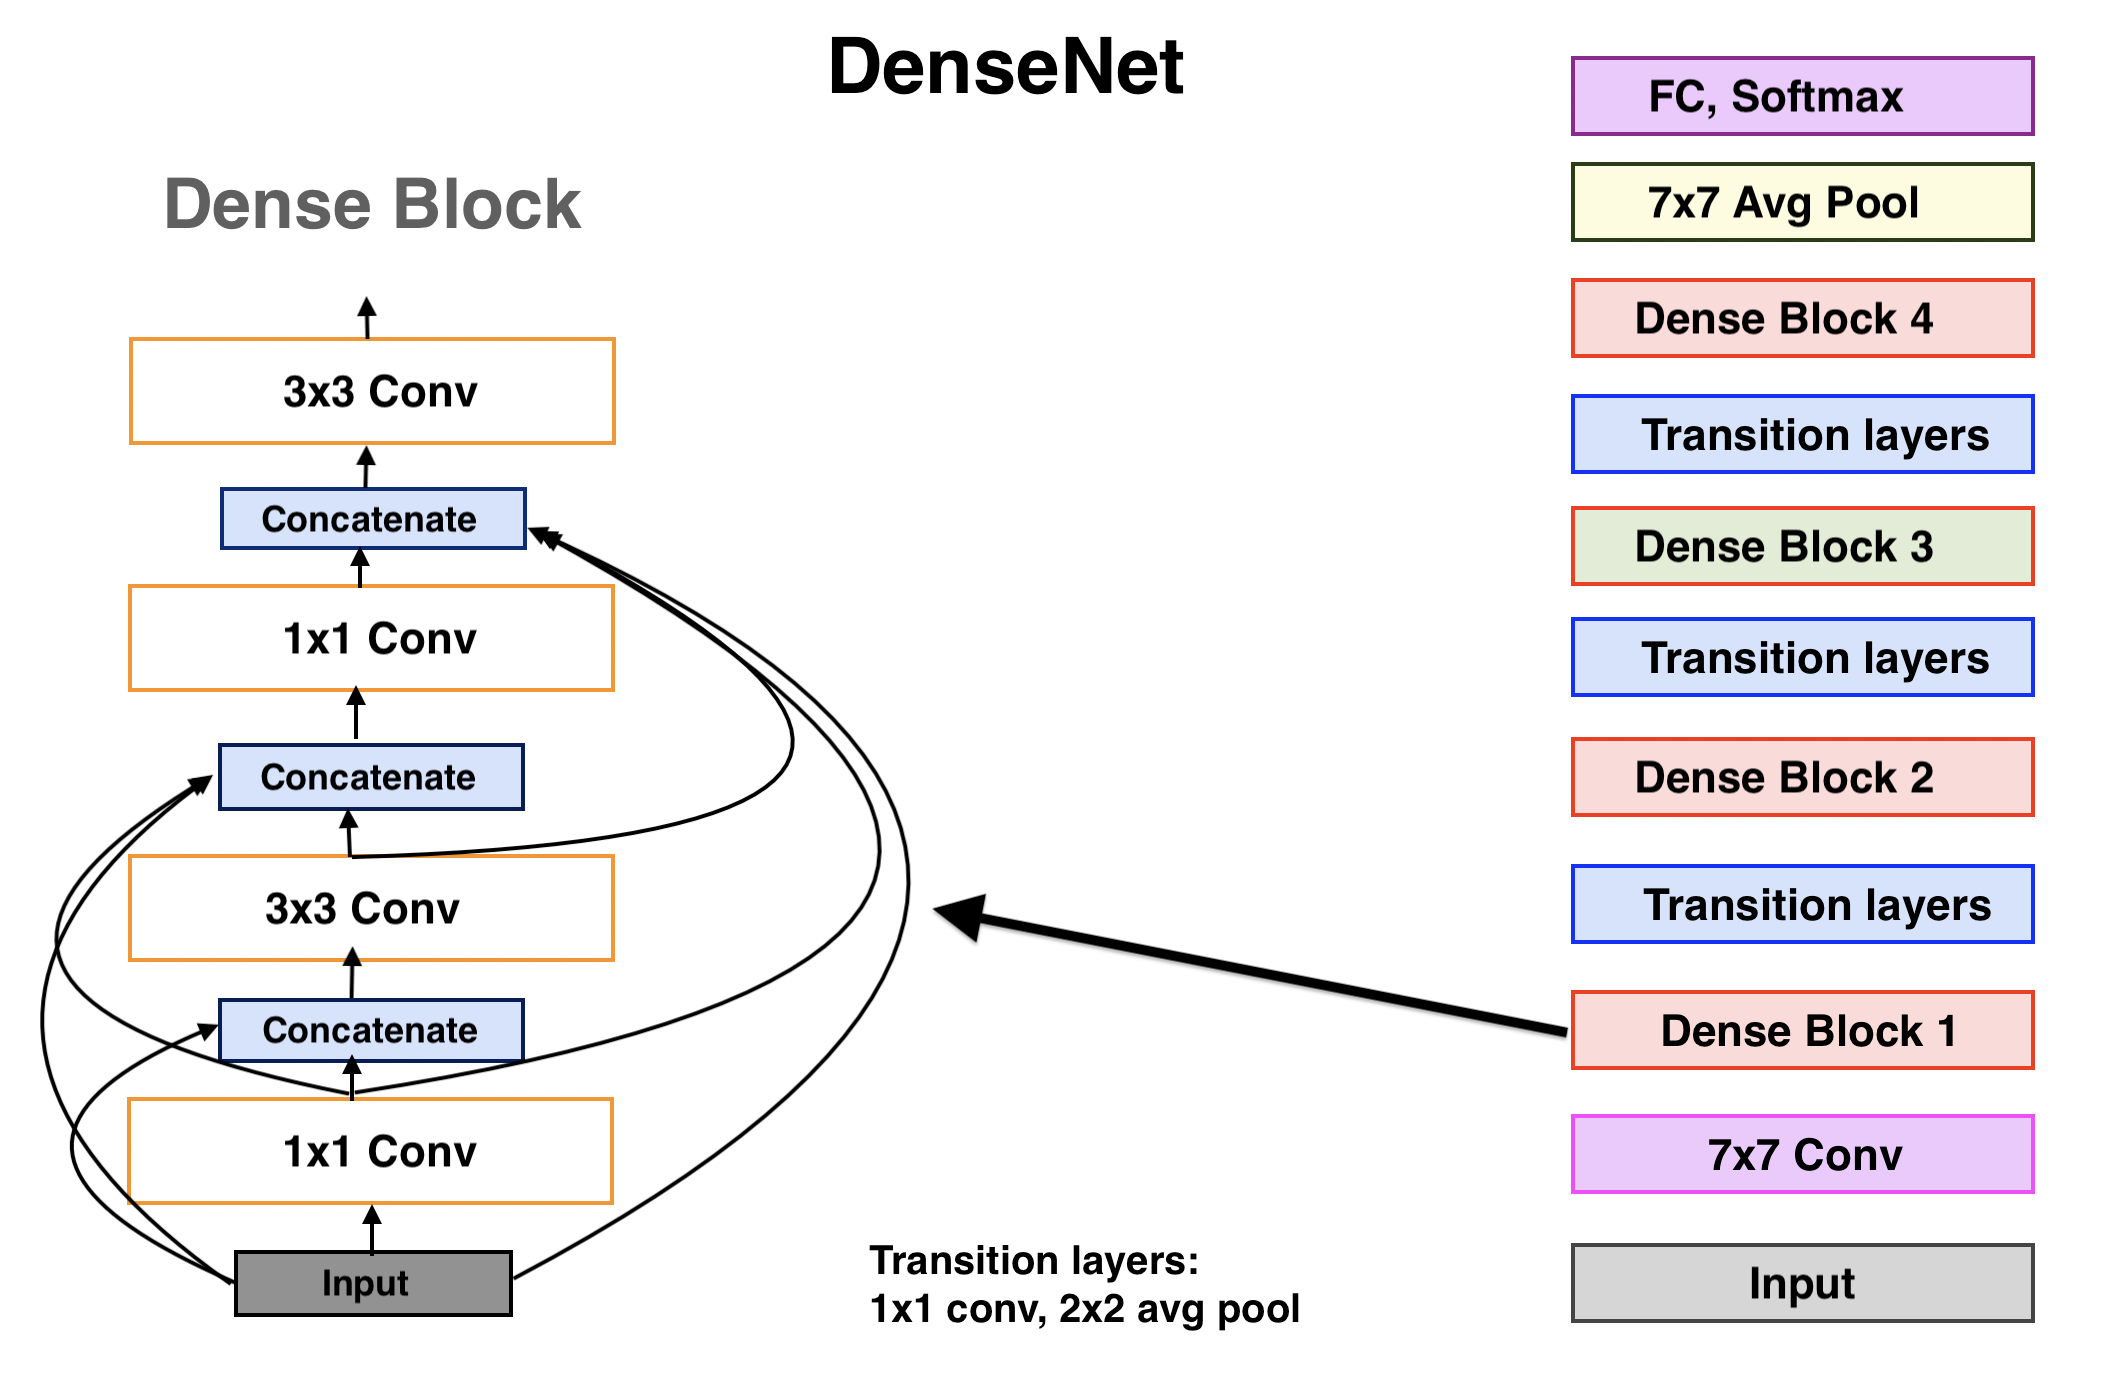

<a name='3'></a>
## 3. DenseNet Implementation

#### Set up

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, utils

In order to implement DenseNet, we have to remember the following:

* Every convolution layer follows batch normalization and ReLU activation layers. 
* Every layer received features from subsequent layers.
* The first convolution layer has a kernel size of 7x7 and `2k` filters. `k` denotes the growth rate of the network. The growth rate for all DenseNet versions is 32. 
* Dense blocks are repeated a number of times as shown in below image. The 1x1 conv layers in dense blocks have 4k filters while the 3x3 conv layers have k filters. 
* Every 3x3 conv layer is padded with one zero pixel to keep the size of the feature maps fixed. 

* After every dense block, there are transition layers that are  1x1 conv and 2x2 average pooling. The mere goal of transition layers is to reduce the feature maps produced by the latter dense block with a compression factor `theta`. The value of theta range between 0 and 1, but we will set theta to 0.5 in this implementation, means the channels of the dense blocks will be halved after after going through transition layers. The last dense block doesn't have transition layers.
* As always, the last classification layer is a fully connected layer with softmax activation. Per imagenet dataset, the number of units are 1000.

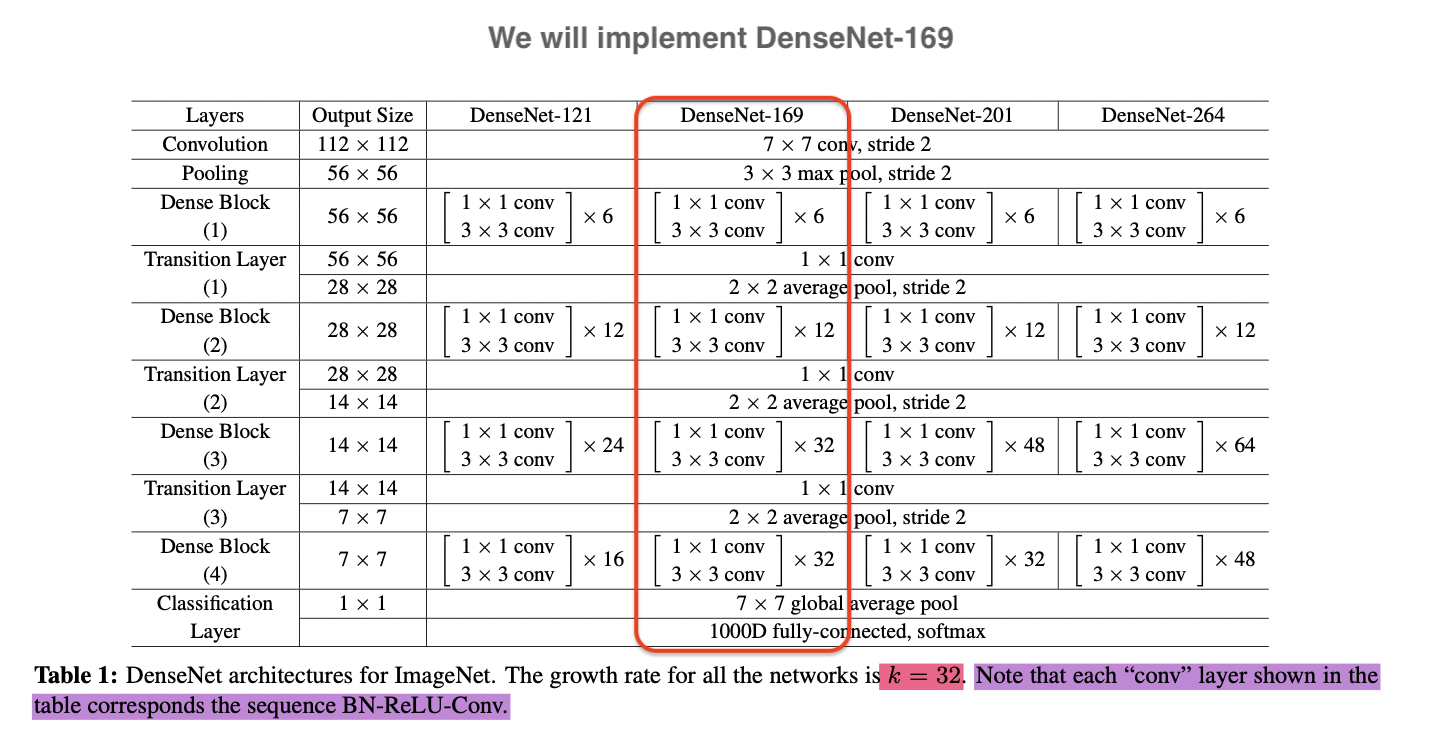

Let's start with implementing dense block and transition layers since they are the main building block of the network.

#### Dense Block

In [3]:
def dense_block(input_tensor, k, block_reps):
  """
  tensor: input tensor from the previous layers
  k: growth rate
  block_reps: Number of times the block is repeated
  Return the concatenated tensors
  """
  for _ in range(block_reps):

    x = layers.BatchNormalization()(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=4*k, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=k, kernel_size=3, padding='same')(x)

    output_tensor = layers.Concatenate()([input_tensor, x])

    return output_tensor

#### Transition Layers

In [4]:
def transition_layers(input_tensor, theta=0.5):
  """
  input_tensor: tensor from the previous dense block
  theta: compression factor, to be multiplied to the output feature maps...
  of the previous dense block.
  return the output tensor
  """

  filters = input_tensor.shape[-1] * theta

  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filters, kernel_size=1)(x)
  output_tensor = layers.AveragePooling2D(pool_size=2, strides=2)(x)

  return output_tensor

Now that we built the dense block and transition layers, we can build the whole DenseNet architecture. 

#### DenseNet-169

In [5]:
k = 32 #growth rate

input = layers.Input(shape=(224,224,3))
x = layers.BatchNormalization()(input)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=2*k, kernel_size=7, strides=2)(x)
x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

x = dense_block(x, 32, 6)
x = transition_layers(x)

x = dense_block(x, 32, 12)
x = transition_layers(x)

x = dense_block(x, 32, 32)
x = transition_layers(x)

x = dense_block(x, 32, 32)

x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1000, activation='softmax')(x)

densenet = tf.keras.Model(input, output)

We can display the model summary and plot the model...

In [6]:
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 224, 224, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

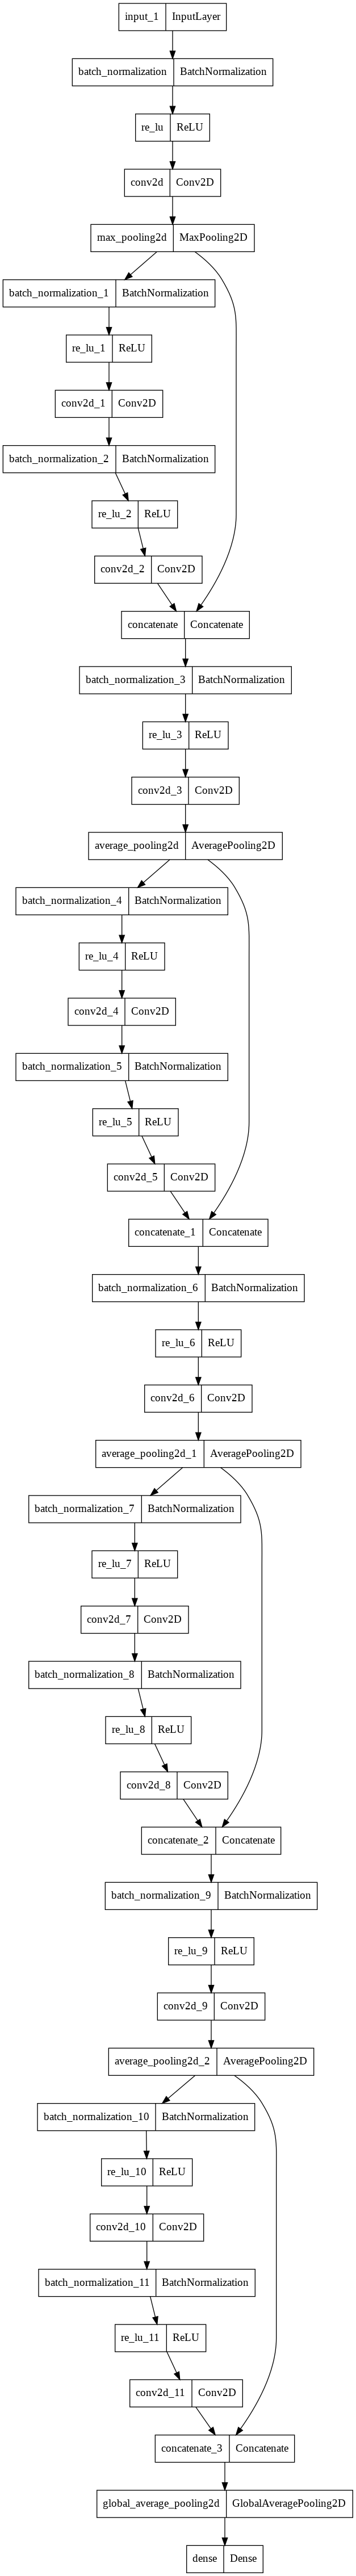

In [7]:
utils.plot_model(densenet)

<a name='4'></a>

## 4. Final Notes

This was the implementation of DenseNet. DenseNet is a Convnet architecture that is exactly like ResNet. The main difference is that ResNet uses addition in residual blocks whereas DenseNet uses concatenation. 

We have implemented DenseNet-169, but there are several versions of DenseNet. 

#### References for other similar implementations
* [Keras Applications, DenseNet](https://github.com/keras-team/keras-applications/blob/master/keras_applications/densenet.py)
* [Machine Learning Tokyo](https://github.com/Machine-Learning-Tokyo/CNN-Architectures/tree/master/Implementations/DenseNet)

### [BACK TO TOP](#0)